<a href="https://colab.research.google.com/github/jayanth142006/paddy-disease-classification/blob/main/paddy2(InceptionResnetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os

In [ ]:
# Set the main directory containing subfolders of images
main_dir = "/content/drive/MyDrive/paddy"  # Change this to your main folder path
output_dir = "/content/drive/MyDrive/paddy2"  # Change this to your desired output directory
prefix = "image"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest"
)

# Loop through subfolders and images
print("[INFO] Processing images...")
for subdir, dirs, files in os.walk(main_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_path = os.path.join(subdir, file)
            rel_path = os.path.relpath(subdir, main_dir)
            save_subdir = os.path.join(output_dir, rel_path)
            os.makedirs(save_subdir, exist_ok=True)

            print(f"[INFO] Processing {image_path}...")
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)

            # Generate augmented images and save them
            total = 0
            imageGen = aug.flow(image, batch_size=1, save_to_dir=save_subdir,
                                 save_prefix=prefix, save_format="jpg")

            for img in imageGen:
                total += 1
                if total == 10:
                    break

print(f"[INFO] Augmented images saved in {output_dir}")

[INFO] Processing images...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/01338330.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/0162038.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/0162039.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/22_23_1.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/4-Figure1-1.png...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/bacterial blight.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/bacterial-leaf-blight-3 (1).jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/80112277.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/bacterial-blight-xanthomonas-oryzae-disease-lesions-on-rice-crop-BX3M40.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/bacterial-leaf-blight-1.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/bacterial_blight/800

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = '/content/drive/MyDrive/paddy2'
img_size = (299, 299)
batch_size = 32
num_classes = 10 # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5156 images belonging to 10 classes.
Found 1284 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze Initial Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5258s 32s/step - accuracy: 0.3136 - loss: 1.8064 - val_accuracy: 0.6153 - val_loss: 1.0189
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.5350 - loss: 1.1972 - val_accuracy: 0.6955 - val_loss: 0.8329
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.6376 - loss: 0.9739 - val_accuracy: 0.7632 - val_loss: 0.6820
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.6523 - loss: 0.8953 - val_accuracy: 0.7648 - val_loss: 0.6332
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.6836 - loss: 0.8356 - val_accuracy: 0.7936 - val_loss: 0.5714
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7001 - loss: 0.7896 - val_accuracy: 0.8084 - val_loss: 0.5293
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.7190 - loss: 0.7358 - val_accuracy: 0.8123 - val_loss: 0.4753
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7228 - loss: 0.7025 - val_ac

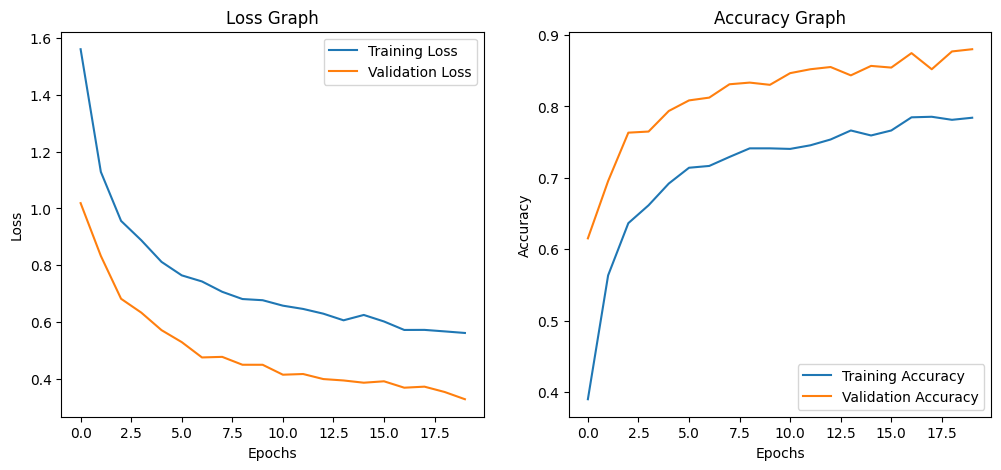

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 55s 820ms/step
Before Fine-Tuning:
                     precision    recall  f1-score   support

         False_smut       0.95      0.95      0.95       184
   bacterial_blight       0.95      0.94      0.94       262
              blast       0.91      0.84      0.88       190
          brownspot       0.79      0.67      0.73       190
grain_discoloration       0.95      0.70      0.81        27
              hispa       0.79      0.98      0.88       192
        leaf_streak       0.93      0.85      0.89        73
      sheath_blight       0.84      0.96      0.90        51
         sheath_rot       0.89      0.88      0.89        66
             tungro       0.83      0.90      0.86        49

           accuracy                           0.88      1284
          macro avg       0.88      0.87      0.87      1284
       weighted avg       0.88      0.88      0.88      1284



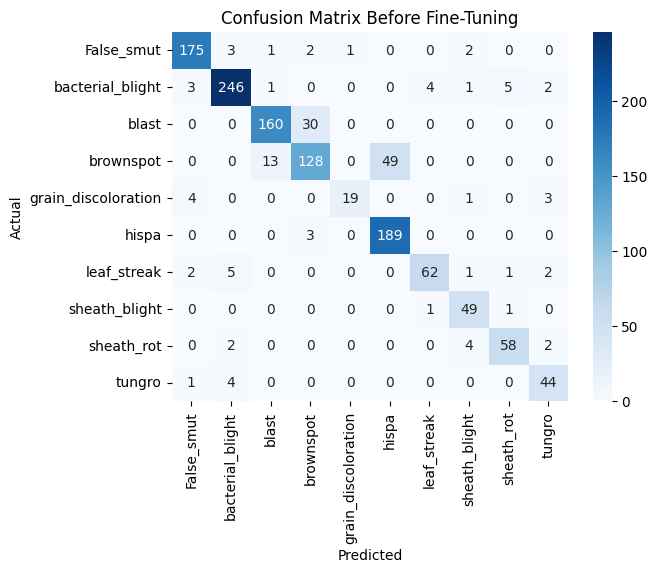

In [ ]:
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
for layer in base_model.layers[:682]:
    layer.trainable = False
for layer in base_model.layers[682:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7483 - loss: 0.7154 - val_accuracy: 0.9128 - val_loss: 0.2209
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8829 - loss: 0.3233 - val_accuracy: 0.9572 - val_loss: 0.1204
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9156 - loss: 0.2387 - val_accuracy: 0.9634 - val_loss: 0.1214
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9305 - loss: 0.1865 - val_accuracy: 0.9766 - val_loss: 0.0697
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9473 - loss: 0.1668 - val_accuracy: 0.9798 - val_loss: 0.0660
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9557 - loss: 0.1271 - val_accuracy: 0.9821 - val_loss: 0.0558
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9579 - loss: 0.1162 - val_accuracy: 0.9766 - val_loss: 0.0583
Epoch 8/20
124/162 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9573 - loss: 0.1308

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


NameError: name 'history_finetune' is not defined

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()